In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
def data_process(stock):
    df = pd.read_csv(stock + '.csv')
    
    # Set 'Date' as the index
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    # Convert string to numerical
    df['Close/Last'] = df['Close/Last'].replace({r'\$': '', r',': ''}, regex=True).astype(float)
    
    return df

# Stock selection
SPY = data_process('SPY') # S&P 500
AAPL = data_process('AAPL') # Apple
TSLA = data_process('TSLA') # Tesla
NVDA = data_process('NVDA') # NVIDIA
AEP = data_process('AEP') # Electricity

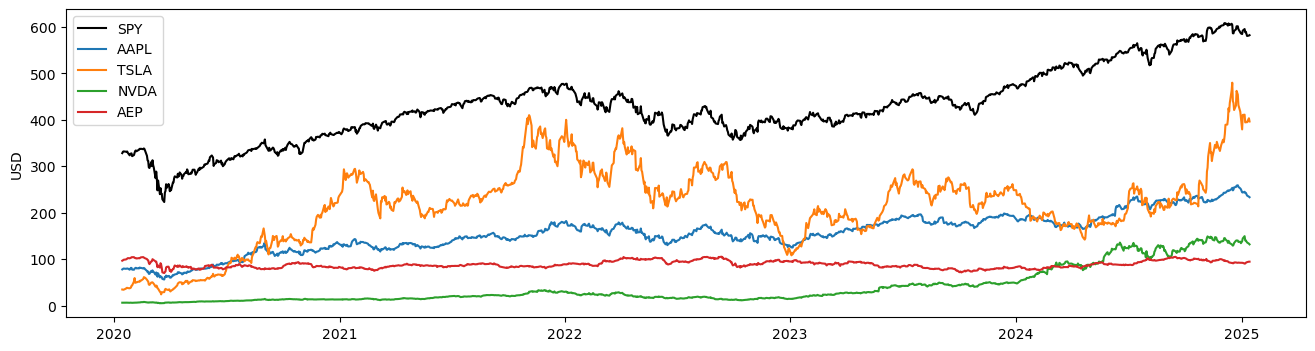

In [5]:
plt.figure(figsize=(16, 4))
plt.plot(SPY['Close/Last'], color='k', label='SPY')
plt.plot(AAPL['Close/Last'], label='AAPL')
plt.plot(TSLA['Close/Last'], label='TSLA')
plt.plot(NVDA['Close/Last'], label='NVDA')
plt.plot(AEP['Close/Last'], label='AEP')

plt.ylabel('USD')
plt.legend()
plt.show()

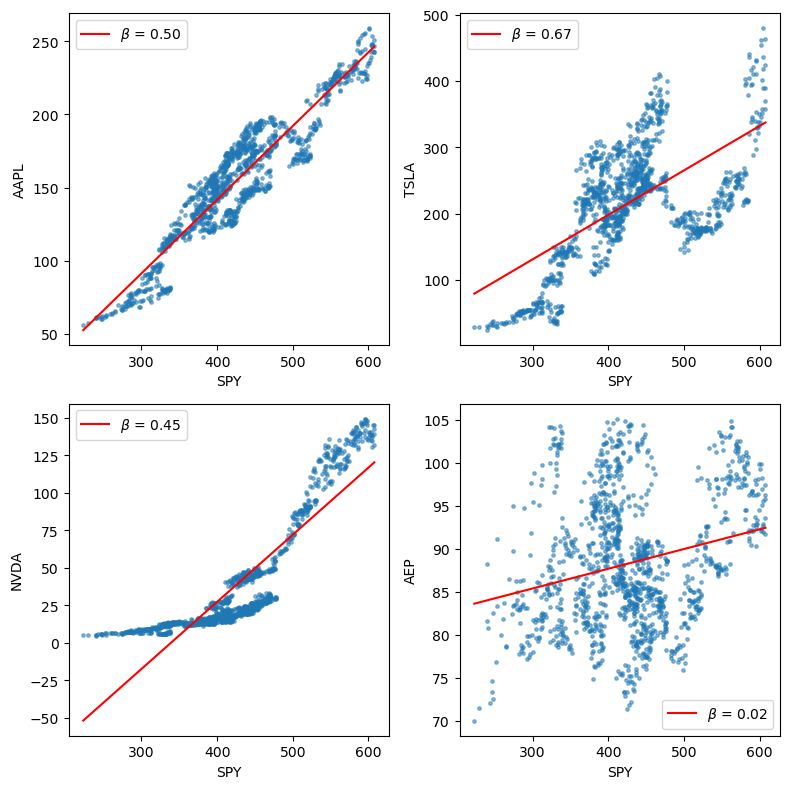

In [7]:
def scatter_plot(df, stock, ax):
    ax.scatter(SPY['Close/Last'], df['Close/Last'], alpha=0.5, s=6)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(SPY['Close/Last'], df['Close/Last'])
    x_vals = np.array([SPY['Close/Last'].min(), SPY['Close/Last'].max()])
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, color='r', label=r'$\beta$ = {:.2f}'.format(slope))
    
    ax.set_xlabel('SPY')
    ax.set_ylabel(stock)
    ax.legend()

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
dfs = [AAPL, TSLA, NVDA, AEP]
stocks = ['AAPL', 'TSLA', 'NVDA', 'AEP']
for i, ax in enumerate(axes.flat):
    scatter_plot(dfs[i], stocks[i], ax)

plt.tight_layout()
plt.show()

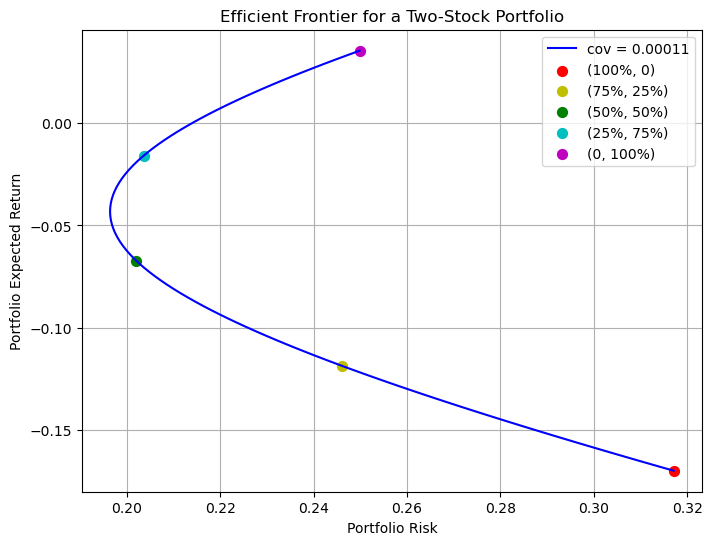

In [9]:
def annual_return(df):
    DR = df['Close/Last'].pct_change()
    R = DR.mean() * 252
    sigma = DR.std() * np.sqrt(252)
    return DR, R, sigma

def portfolio_return(df1, df2):
    DR_A, R_A, sigma_A = annual_return(df1)
    DR_B, R_B, sigma_B = annual_return(df2)
    cov_AB = DR_A.cov(DR_B)
    
    w_A = np.linspace(0, 1, 100)
    w_B = 1 - w_A
    R_P = w_A * R_A + w_B * R_B
    SD_P = np.sqrt(w_A**2 * sigma_A**2 + w_B**2 * sigma_B**2 + 2 * w_A * w_B * cov_AB)
    
    plt.figure(figsize=(8, 6))
    plt.plot(SD_P, R_P, color='b', label=r'cov = {:.5f}'.format(cov_AB))
    colors = ['r','y','g','c','m']
    labels = ['(100%, 0)','(75%, 25%)','(50%, 50%)','(25%, 75%)','(0, 100%)']
    for i in range(5):
        w_A, w_B = 1-i/4, i/4
        x = w_A * R_A + w_B * R_B
        y = np.sqrt(w_A**2 * sigma_A**2 + w_B**2 * sigma_B**2 + 2 * w_A * w_B * cov_AB)
        plt.scatter(y, x, color=colors[i], label=labels[i], s=50)
    
    plt.title('Efficient Frontier for a Two-Stock Portfolio')
    plt.xlabel('Portfolio Risk')
    plt.ylabel('Portfolio Expected Return')
    plt.grid(True)
    plt.legend()
    plt.show()

#Available stocks: SPY, AAPL, TSLA, NVDA, AEP
portfolio_return(AAPL, AEP)